In [67]:
import torch
from stable_baselines3 import PPO
from rl_env import DraftEnv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [68]:
reward_scalar = 326.3910530956667

env = DraftEnv(stochastic_temp=1)


state, _ = env.reset()

# Update draft  with API

In [129]:
import requests
import json
from rl_env import DraftEnv, STARTER_COMPOSITION

env = DraftEnv(stochastic_temp=.5)

# draft_id = "1119159922530312193"  # THE REAL DEAL
draft_id = "1134366722829574144"  


url = f"https://api.sleeper.app/v1/draft/{draft_id}/picks"
resp = requests.get(url).json()
print(f"Number of picks: {len(resp)}")

for pick in resp:
    # print(pick)
    
    if pick['metadata']['player_id'] not in env.all_players['sleeper_id'].values:
        print(f"Player {pick['metadata']['player_id']}, {pick['metadata']['first_name']}, {pick['metadata']['last_name']} not in all_players")
        continue
    mgr_num = int(pick['draft_slot']) - 1
    turn_num = int(pick['pick_no']) - 1
    d_round = int(pick['round'])
    sleeper_id = pick['metadata']['player_id']
    full_name = pick['metadata']['first_name'] + " " + pick['metadata']['last_name']
    fp_mean = env.all_players.loc[env.all_players['sleeper_id'] == sleeper_id, 'mean'].values[0]
    fp_std = env.all_players.loc[env.all_players['sleeper_id'] == sleeper_id, 'std'].values[0]
    team = env.all_players.loc[env.all_players['sleeper_id'] == sleeper_id, 'team'].values[0]
    position = env.all_players.loc[env.all_players['sleeper_id'] == sleeper_id, 'position'].values[0]
    
    if position not in ["RB", "WR", "TE"]:
        team_pos = position
    else:
        needed_pos = env.get_needed_pos_counts(mgr_num, flex=True)
        if needed_pos[position] > 0:
            team_pos = position
        else:
            team_pos = "FLEX"
    
    env.draft.iloc[turn_num] = {
    # env.draft.loc[(env.draft['round']==d_round) and (env.draft['mgr'] == mgr_num)] = {
        'mgr': mgr_num,
        'sleeper_id': sleeper_id,
        'full_name': full_name,
        'fp_mean': fp_mean,
        'fp_std': fp_std,
        'team': team,
        'position': position,
        'team_pos': team_pos,
        'round': d_round
    }

    
    # env.draft.iloc[turn_num] = [mgr_num, sleeper_id, full_name]
# env.draft.groupby('mgr').agg({'fp_mean': 'sum'}).sort_values(by='fp_mean', ascending=False)
# env.get_mgr_rankings(starters=True)

# def update_draft(env, draft_id)


Number of picks: 180
Player 5848, Hollywood, Brown not in all_players


# Run Prediction

In [126]:


# -- Artificially omit players from the draft pool -- #
# omit_ids = ["BAL"]
# omit_pos = ["DEF"]
# env.open_players = env.open_players.loc[~env.open_players['sleeper_id'].isin(omit_ids)]
# # env.open_players = env.open_players.loc[~env.open_players['position'].isin(omit_pos)]
# env.update_state()
# --------------------------------------------------- # 

pos_dict = {0: "QB", 1: "RB", 2: "WR", 3: "TE", 4: "K", 5: "DEF"}

model_paths = {
    "mod1": "logs/PPO_20240827-143658/best_model.zip", # best model no def/k penalties
    "mod2": "logs/PPO_20240828-000621/best_model.zip", # first model with def/k penalties
    "mod3": "logs/PPO_20240828-101740/best_model_20240828-101740.zip", # second model with def/k penalties
    "mod4": "logs/PPO_20240829-001139/best_model.zip" # model 1 retrained with new rewards
}


models = {k: PPO.load(v, env=env) for k, v in model_paths.items()}
# mod1 = PPO.load(model_path1, env=env)
# mod2 = PPO.load(model_path2, env=env)
# mod3 = PPO.load(model_path3, env=env)

_ = [mod.policy.eval() for mod in models.values()]
# mod1.policy.eval()
# mod2.policy.eval()
# mod3.policy.eval()

rl_mgr = 1
with torch.no_grad():
    env.open_players = env.open_players.loc[~env.open_players['sleeper_id'].isin(env.draft['sleeper_id'])]
    state = env.update_state()
    # action, _states = best_model.predict(state, deterministic=True)
   # Get action distribution
    # action_dist1 = mod1.policy.get_distribution(torch.tensor(state).unsqueeze(0))
    # action_dist2 = mod2.policy.get_distribution(torch.tensor(state).unsqueeze(0))
    # action_dist3 = mod3.policy.get_distribution(torch.tensor(state).unsqueeze(0))
    action_dists = {
        k: mod.policy.get_distribution(torch.tensor(state).unsqueeze(0)) for k, mod in models.items()
    }
    
    # Get the logits (raw action probabilities before softmax)
    # logits1 = action_dist1.distribution.logits.squeeze()
    # logits2 = action_dist2.distribution.logits.squeeze()
    # logits3 = action_dist3.distribution.logits.squeeze()
    logits = {
        k: ad.distribution.logits.squeeze() for k, ad in action_dists.items()
    }
    
    # Convert logits to probabilities
    # probs1 = torch.softmax(logits1, dim=-1)
    # probs2 = torch.softmax(logits2, dim=-1)
    # probs3 = torch.softmax(logits3, dim=-1)
    probs = {
        k: torch.softmax(logit, dim=-1) for k, logit in logits.items()
    }
    
    
    
    choices = {
        k: probs[k].argmax().item() for k in probs.keys()
    }
    

    choice1 = probs1.argmax().item()
    print(f"Mod 1 choice: {pos_dict[choice1]}")
    # print(env.open_players.loc[env.open_players['position'] == pos_dict[choice1]].iloc[0])
    ps1 = [(pos_dict[i], np.round(prob.item(), 3)) for i, prob in enumerate(probs1)]
    # order ps1 by probability
    ps1 = sorted(ps1, key=lambda x: x[1], reverse=True)
    print(ps1)
    choice2 = probs2.argmax().item()
    print(f"Mod 2 choice: {pos_dict[choice2]}")
    # print(env.open_players.loc[env.open_players['position'] == pos_dict[choice2]].iloc[0])
    ps2 = [(pos_dict[i], np.round(prob.item(), 3)) for i, prob in enumerate(probs2)]
    ps2 = sorted(ps2, key=lambda x: x[1], reverse=True)
    print(ps2)
    choice3 = probs3.argmax().item()
    print(f"Mod 3 choice: {pos_dict[choice3]}")
    # print(env.open_players.loc[env.open_players['position'] == pos_dict[choice3]].iloc[0])
    ps3 = [(pos_dict[i], np.round(prob.item(), 3)) for i, prob in enumerate(probs3)]
    ps3 = sorted(ps3, key=lambda x: x[1], reverse=True)
    print(ps3)

    
# p = env.open_players.loc[env.open_players['position'] == pos_dict[action.item()]].iloc[0]
# print(p['full_name'], p['sleeper_id'])
# env.draft

# -- Add players back who were artificially omitted -- #
# players_to_add = env.all_players.loc[env.all_players['sleeper_id'].isin(omit_ids)]
# # players_to_add = players_to_add.loc[players_to_add['position'].isin(omit_pos)]
# players_to_add = players_to_add.loc[~players_to_add['sleeper_id'].isin(env.draft['sleeper_id'])]
# env.open_players = pd.concat([env.open_players, players_to_add])
# _ = env.update_state()
# ---------------------------------------------------- # 




Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Mod 1 choice: QB
[('QB', 0.48), ('K', 0.282), ('DEF', 0.187), ('RB', 0.028), ('WR', 0.015), ('TE', 0.008)]
Mod 2 choice: DEF
[('DEF', 0.496), ('QB', 0.451), ('K', 0.027), ('WR', 0.014), ('TE', 0.009), ('RB', 0.003)]
Mod 3 choice: TE
[('TE', 0.871), ('K', 0.087), ('DEF', 0.021), ('WR', 0.016), ('QB', 0.004), ('RB', 0.001)]


# Plot model predictions

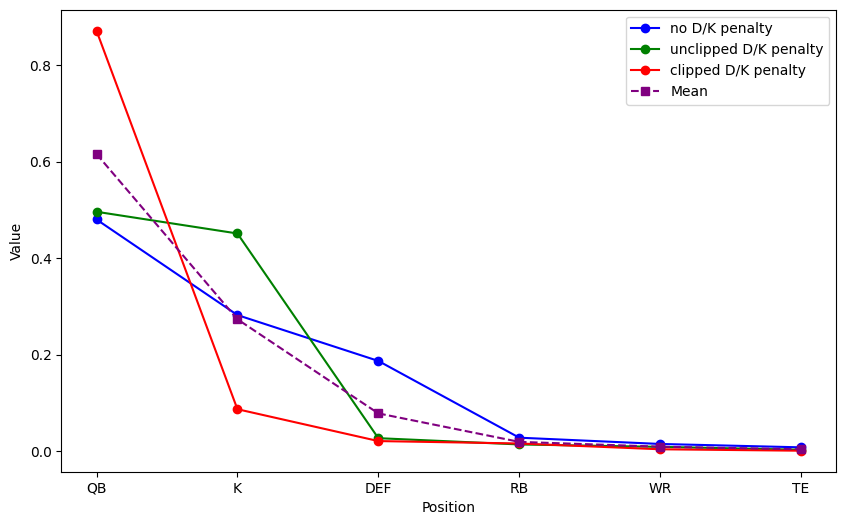

In [127]:

# Extracting positions and values from each list
positions = [pos[0] for pos in ps1]
values1 = [val[1] for val in ps1]
values2 = [val[1] for val in ps2]
values3 = [val[1] for val in ps3]

# Calculating the mean of the values for each position
mean_values = np.mean([values1, values2, values3], axis=0)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(positions, values1, label='no D/K penalty', marker='o', color='blue')
plt.plot(positions, values2, label='unclipped D/K penalty', marker='o', color='green')
plt.plot(positions, values3, label='clipped D/K penalty', marker='o', color='red')
plt.plot(positions, mean_values, label='Mean', marker='s', linestyle='--', color='purple')

# Adding labels and title
plt.xlabel('Position')
plt.ylabel('Value')
plt.title('')
plt.legend()

# Display plot
plt.show()

# Plot Players

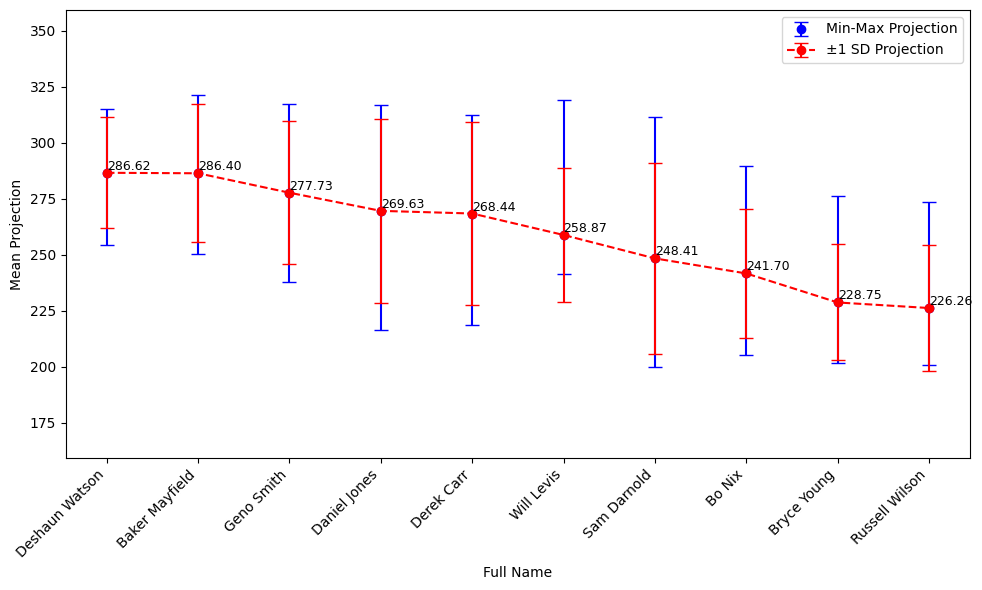

In [128]:
pos = ["QB"]
# pos = ["RB"]
# pos = ["WR"]
# pos = ["TE"]
# pos = ["DEF"]
# pos = ["K"]
# pos = ["RB", "WR", "TE"]
# pos = ["RB", "WR"]


f = "data/sleeper_proj_hist.csv"
df = pd.read_csv(f)
df = df.loc[~df['sleeper_id'].isin(env.draft['sleeper_id'])].loc[df['position'].isin(pos)].sort_values(by='mean_proj', ascending=False).head(10)

# X-axis: full_name, Y-axis: mean_proj
x = df['full_name']
y = df['mean_proj']

# Error bars: min_proj to max_proj
error_min_max = [y - df['min_proj'], df['max_proj'] - y]

# Error bars: mean_proj +/- 1 sd_proj
error_sd = [df['sd_proj'], df['sd_proj']]

# Plotting
plt.figure(figsize=(10, 6))

# Main plot
plt.errorbar(x, y, yerr=error_min_max, fmt='o', label='Min-Max Projection', capsize=5, color='blue')
plt.errorbar(x, y, yerr=error_sd, fmt='o', label='±1 SD Projection', capsize=5, color='red', linestyle='dashed')

# Adding text labels next to each dot using .iloc[] for positional access
for i in range(len(x)):
    plt.text(x.iloc[i], y.iloc[i], f'{y.iloc[i]:.2f}', fontsize=9, ha='left', va='bottom')
    
# Setting the y-axis range to 200 with the mean of all mean_proj centered
mean_of_means = y.mean()
y_min = mean_of_means - 100
y_max = mean_of_means + 100
plt.ylim(y_min, y_max)

# Adding labels and title
plt.xlabel('Full Name')
plt.ylabel('Mean Projection')
# plt.title('Mean Projection with Min-Max and ±1 SD Error Bars')
plt.legend()

# Display plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# import pandas as pd
# pd.set_option('display.max_rows', None)
# # show top 10 players of each position

# print("RB")
# display(env.open_players.loc[env.open_players['position'] == 'RB'].sort_values(by='mean', ascending=False).head(10))
# print("WR")
# display(env.open_players.loc[env.open_players['position'] == 'WR'].sort_values(by='mean', ascending=False).head(10))
# print("TE")
# display(env.open_players.loc[env.open_players['position'] == 'TE'].sort_values(by='mean', ascending=False).head(10))
# print("QB")
# display(env.open_players.loc[env.open_players['position'] == 'QB'].sort_values(by='mean', ascending=False).head(10))
# print("K")
# display(env.open_players.loc[env.open_players['position'] == 'K'].sort_values(by='mean', ascending=False).head(10))
# print("DEF")
# display(env.open_players.loc[env.open_players['position'] == 'DEF'].sort_values(by='mean', ascending=False).head(10))

# Score draft

In [133]:
r = env.get_mgr_rankings(starters=True)
r['fp_mean'] *= reward_scalar
r

,rank,mgr,fp_mean
0,1,7,1763.158357
1,2,0,1739.209072
2,3,6,1734.162236
3,4,4,1730.942293
4,5,1,1730.235997
5,6,8,1725.623545
6,7,9,1722.753261
7,8,11,1721.125206
8,9,3,1710.986523
9,10,10,1703.391861
